This script uses Bayesian Optimisation to optimise the hyper parameters of a Random Forest model forecasting isoprene.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import random
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

random.seed(8)
np.random.seed(8)

In [14]:
data = pd.read_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data/historical_data.csv')
# removing columns with less than 5% corrilation with isoprene or one of the 95% or greater colinear variables 
data = data.drop(columns=['wsp', 'no_drought', 'precipitation (mm)', 'mfpar'])
print(data)

                      time  isoprene  previous_week_avg  51_week_avg  \
0      2021-01-23 01:00:00  0.004636           0.013394     0.022043   
1      2021-01-23 02:00:00  0.004636           0.013394     0.022043   
2      2021-01-23 03:00:00  0.004636           0.013394     0.022043   
3      2021-01-23 04:00:00  0.004636           0.013394     0.022043   
4      2021-01-23 05:00:00  0.004636           0.013394     0.022043   
...                    ...       ...                ...          ...   
27718  2024-12-30 20:00:00  0.005008           0.013522     0.007293   
27719  2024-12-30 21:00:00  0.005008           0.013522     0.007293   
27720  2024-12-30 22:00:00  0.005008           0.013522     0.007293   
27721  2024-12-30 23:00:00  0.005008           0.013522     0.007293   
27722  2024-12-31 00:00:00  0.005008           0.013522     0.007293   

       24_hour_isoprene     temp_f       nox        solr       relh  \
0              0.004636  29.215617  3.406550    0.000000  72.631

In [15]:
# setting up train and test sets with train set being data before 2024
validation_split_date = "2023-01-01"
test_split_date = "2024-01-01"

train = data[data["time"] < validation_split_date] 
validation = data[(data["time"] >= validation_split_date) & (data["time"] < test_split_date)]
test = data[data["time"] >= test_split_date]  

In [16]:
# when working on the boosted tree model I referenced the documetnation from this page (and others linked from it): https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html https://xgboosting.com/xgboost-booster.predict-vs-xgbregressor.predict/

X_train = train.drop(columns=["time", "isoprene"])  
y_train = train["isoprene"]

X_validate = validation.drop(columns=["time", "isoprene"])
y_validate = validation["isoprene"] 

X_test = test.drop(columns=["time", "isoprene"])
y_test = test["isoprene"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidate = xgb.DMatrix(X_validate, label=y_validate)
dtest = xgb.DMatrix(X_test, label=y_test)

# I tested using a penilzed function to encurage the model to not underestimate so much (it underesimates peaks a lot during the summer)
# however this didn't work particularly well (made my results worth without meaningfuly helping to correct under predictions during the summer)
# def penalty_func(y_true, y_pred, penalty=1.5):
#     residuals = y_true - y_pred
#     penalized_residuals = np.where(residuals > 0, penalty * (residuals ** 2), residuals ** 2)
#     return np.sqrt(np.mean(penalized_residuals))

def xgb_evalualuating_func(max_depth, eta, subsample, colsample_bytree, num_parallel_tree):
    '''
    This function sets up the parameters for the boosted random forest model such that they can be altered for hyper parameter tuning 
    then it trains a model and evaluates the test set (via RMSE) (this can then be passed on to the optimiser for hyper parameter tuning)

    Args:
        (all parameters for boosted tree model discussed here: https://xgboost.readthedocs.io/en/stable/parameter.html)
        max_depth: max depth of each tree
        eta: learning rate
        subsample: persentage of data used for training a tree 
        coslsample_bytree: persentage of predictors used for training a tree
        num_parallel_tree: amount of trees to train in parallel

    Returns 
        The RMSE of the model 
    '''
    params = {
        "objective": "reg:squarederror",
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "max_depth": int(max_depth),  
        "num_parallel_tree": int(num_parallel_tree),
        "eta": eta,
        "tree_method": "hist",
    }

    rf_model = xgb.train(params, dtrain, num_boost_round=10)
    y_pred = rf_model.predict(dvalidate)

    # rmse = penalty_func(y_train, y_pred, penalty=35.0)
    rmse = np.sqrt(mean_squared_error(y_validate, y_pred))
    return -rmse  

param_options = {
    "colsample_bytree": (0.05, 1.0),
    "subsample": (0.05, 1.0),
    "max_depth": (3, 25),
    "num_parallel_tree": (5, 250),
    "eta": (0.01, 1.0),
}

# here I am applying baysianoptimization using the xgboost function abouve as my objective function 
# I referenced this documentiation when setting up bayesianoptimization https://pypi.org/project/bayesian-optimization/
optimizer = BayesianOptimization(
    f=xgb_evalualuating_func, 
    pbounds=param_options,  
    random_state=8,
    verbose=2  
)

optimizer.maximize(init_points=6, n_iter=15)


|   iter    |  target   | colsam... |    eta    | max_depth | num_pa... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.09212  | 0.8798    | 0.9689    | 22.12     | 135.1     | 0.2711    |
| 2         | -0.09917  | 0.06083   | 0.4362    | 11.85     | 133.1     | 0.5045    |
| 3         | -0.08696  | 0.5776    | 0.548     | 19.74     | 179.5     | 0.6387    |
| 4         | -0.0913   | 0.4548    | 0.2962    | 24.42     | 86.77     | 0.2579    |
| 5         | -0.09729  | 0.1125    | 0.983     | 5.813     | 83.92     | 0.1174    |
| 6         | -0.0929   | 0.2635    | 0.3997    | 22.72     | 89.64     | 0.9855    |
| 7         | -0.08888  | 0.3519    | 0.6924    | 24.32     | 183.6     | 0.4322    |
| 8         | -0.1559   | 0.8177    | 0.123     | 24.3      | 171.3     | 0.799     |
| 9         | -0.1003   | 0.1263    | 0.8786    | 17.19     | 186.0     | 0.9186    |
| 10        | -0.1214   | 0.7047    | 0.1658    | 17.3

In [17]:
# extracting and printing out the best parameters from the optimisation step 
best_params = optimizer.max['params']
best_params["max_depth"] = int(best_params["max_depth"])
best_params["num_parallel_tree"] = int(best_params["num_parallel_tree"])

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': np.float64(0.5775886501312139), 'eta': np.float64(0.5479521573671149), 'max_depth': 19, 'num_parallel_tree': 179, 'subsample': np.float64(0.6386979912982677)}


In [18]:
# reruning the model with the best found parameters 
optimal_params = {
    "objective": "reg:squarederror",
    "max_depth": best_params["max_depth"],  
    "eta": best_params["eta"],  
    "subsample": best_params["subsample"],  
    "colsample_bytree": best_params["colsample_bytree"],  
    "num_parallel_tree": best_params["num_parallel_tree"],  
    "tree_method": "hist"
}
# I referenced this: https://xgboosting.com/xgboost-booster.predict-vs-xgbregressor.predict/
final_model = xgb.train(optimal_params, dtrain, num_boost_round=10)  

y_pred_final = final_model.predict(dtest)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f'Best Forest RMSE: {final_rmse:.4f}')
print(f'Test Set Mean: {np.mean(y_test)}')



Best Forest RMSE: 0.1067
Test Set Mean: 0.04835473629719853


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_79837/835749325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["time"] = pd.to_datetime(test["time"])


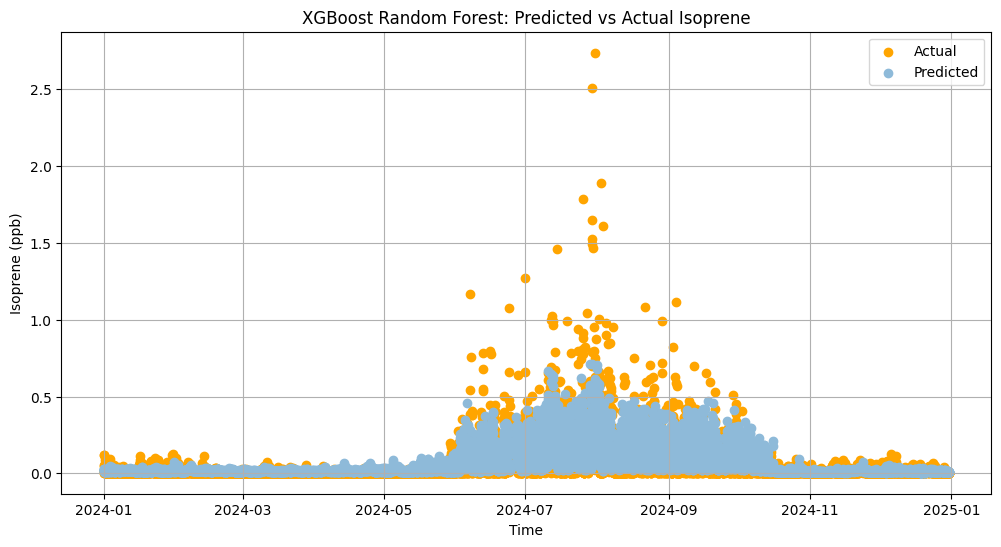

In [19]:

test["time"] = pd.to_datetime(test["time"])
plt.figure(figsize=(12, 6))
plt.scatter(test["time"], y_test, label="Actual", color="orange")
plt.scatter(test["time"], y_pred_final, label="Predicted", color="#8ebad9")
plt.xlabel("Time")
plt.ylabel("Isoprene (ppb)")
plt.title("XGBoost Random Forest: Predicted vs Actual Isoprene")
plt.legend()
plt.grid()
plt.show()


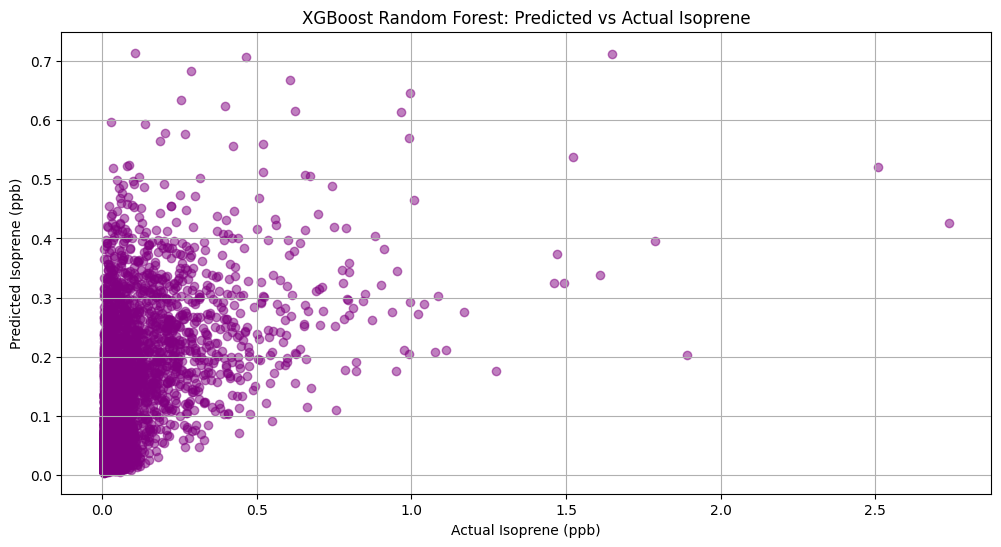

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_final, label="Actual", color="purple", alpha=.5)
plt.xlabel("Actual Isoprene (ppb)")
plt.ylabel("Predicted Isoprene (ppb)")
plt.title("XGBoost Random Forest: Predicted vs Actual Isoprene")
plt.grid()
plt.show()

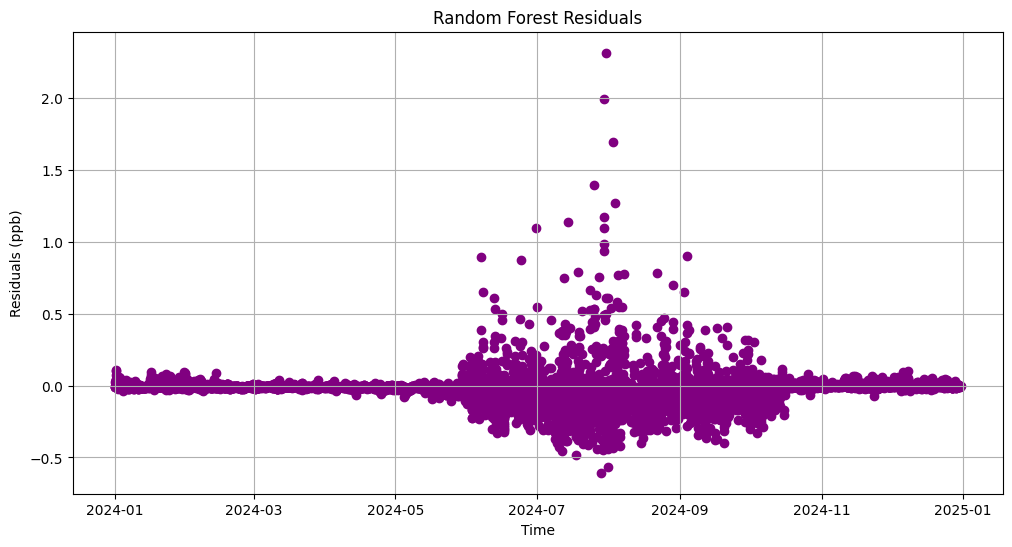

In [21]:
residuals = y_test - y_pred_final
plt.figure(figsize=(12, 6))
plt.scatter(test["time"], residuals, label="Actual", color="purple", linestyle="-")
plt.xlabel("Time")
plt.ylabel("Residuals (ppb)")
plt.title("Random Forest Residuals")
plt.grid()
plt.show()

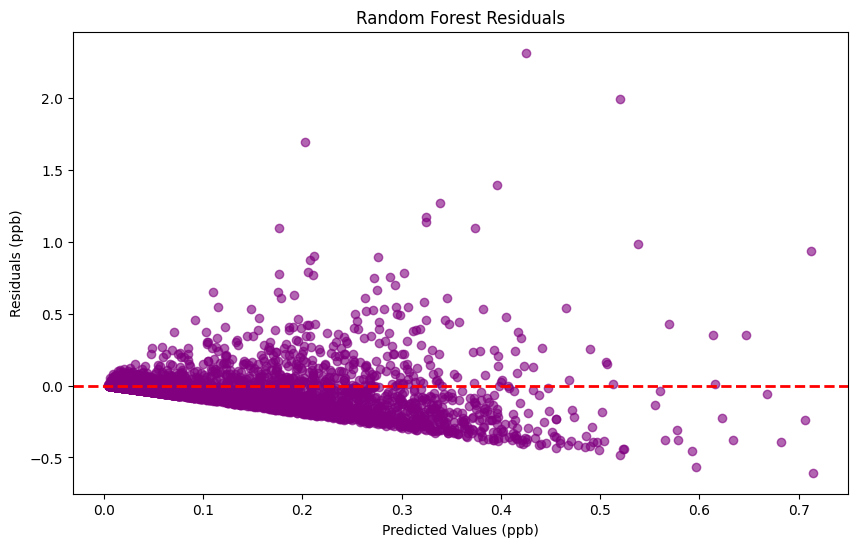

In [22]:

residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals, color="purple", alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  
plt.xlabel('Predicted Values (ppb)')
plt.ylabel('Residuals (ppb)')
plt.title('Random Forest Residuals')
plt.show()

In [23]:
out_df = test.copy()
print(len(out_df))
print(len(y_test))
out_df = out_df[['time']]
out_df['isoprene'] = y_test
out_df['pred'] = y_pred_final
print(out_df)

# saving the results from the model on the test set for comparison with the other models
out_df.to_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data_out/RF_out.csv', index=False)

8210
8210
                     time  isoprene      pred
19513 2024-01-01 00:00:00  0.005157  0.011786
19514 2024-01-01 01:00:00  0.005157  0.015070
19515 2024-01-01 02:00:00  0.013180  0.025812
19516 2024-01-01 03:00:00  0.017840  0.027457
19517 2024-01-01 04:00:00  0.049260  0.021909
...                   ...       ...       ...
27718 2024-12-30 20:00:00  0.005008  0.006606
27719 2024-12-30 21:00:00  0.005008  0.006177
27720 2024-12-30 22:00:00  0.005008  0.006817
27721 2024-12-30 23:00:00  0.005008  0.008818
27722 2024-12-31 00:00:00  0.005008  0.008251

[8210 rows x 3 columns]
